# Summary
- Analysis of fine-tuned models

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import basename, dirname
import torch
import seaborn as sns
sns.set_context("talk")
sns.set_style("white")

from ipywidgets import FloatSlider, interactive
import sys
sys.path.append('..')
from var import fname2mname, network2pair, network_sort_key

In [2]:
# loading in them all made my machine run out of memory
method_l = [
     "maxcorr", 
     "mincorr", 
     "maxlinreg", 
     "minlinreg", 
    "cca", 
    "lincka", 
    # "rbfcka",
]

In [3]:
# Set `res_d`, `network_l`, `num_neurons_d`
base = "/data/sls/temp/belinkov/contextual-corr-analysis/repr_fine_results4_"
res_fname = {method : base + method for method in 
                method_l}

res_d = {}
for method in method_l:
    with open(res_fname[method], 'rb') as f:
        res_d[method] = pickle.load(f)

network_l = [network for network in res_d["cca"]["corrs"]]
network_l = sorted(network_l, key=network_sort_key)

num_neurons_d = {}
for network in network_l:
    num_neurons_d[network] = len(next(iter(res_d["cca"]["corrs"][network].values()))) # god this is a hack

In [4]:
network_l

['bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0',
 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_1',
 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_2',
 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_3',
 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_4',
 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_5',
 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_6',
 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_7',
 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_8',
 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_9',
 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_10',
 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11',
 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12',
 'bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0',
 'bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_1',
 'bert_base_cased-ptb_pos_dev_qnli_include_embedding

# MaxCorr, MinCorr, MaxLinReg, MinLinReg

### Sorts

In [5]:
rk_methods = {"maxcorr", "mincorr", "maxlinreg", "minlinreg"}

In [6]:
neuron_sorts = {network: {} for network in network_l}
for network in network_l:
    for method in rk_methods:
        neuron_sorts[network][method] = res_d[method]["neuron_sort"][network]

In [7]:
# Set `rk_ar_d`, `rk_df_d`, `spearman_d`
rk_ar_d = {}
rk_df_d = {}
spearman_d = {}
for network in network_l:
    # rk_ar[method_ix, neuron] = rank
    # need to invert the permutation
    rk_ar = np.stack([
            [neuron_sorts[network][method].index(neuron) for neuron in range(len(neuron_sorts[network][method]))]
                      for method in rk_methods
    ]).T
    rk_df = pd.DataFrame(rk_ar, columns=list(rk_methods))
    
    rk_ar_d[network] = rk_ar
    rk_df_d[network] = rk_df
    spearman_d[network] = rk_df.corr()

In [8]:
for network in network_l:
    print(network)
    # print(rk_df_d[network])
    print(spearman_d[network])

bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0
            mincorr   maxcorr  minlinreg  maxlinreg
mincorr    1.000000  0.102642   0.278761   0.131333
maxcorr    0.102642  1.000000   0.394246   0.786421
minlinreg  0.278761  0.394246   1.000000   0.461015
maxlinreg  0.131333  0.786421   0.461015   1.000000
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_1
            mincorr   maxcorr  minlinreg  maxlinreg
mincorr    1.000000 -0.106539   0.364858  -0.101160
maxcorr   -0.106539  1.000000   0.117047   0.941126
minlinreg  0.364858  0.117047   1.000000   0.116570
maxlinreg -0.101160  0.941126   0.116570   1.000000
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_2
            mincorr   maxcorr  minlinreg  maxlinreg
mincorr    1.000000 -0.139686   0.342309  -0.128575
maxcorr   -0.139686  1.000000   0.097493   0.968529
minlinreg  0.342309  0.097493   1.000000   0.154233
maxlinreg -0.128575  0.968529   0.154233   1.000000
bert_base_cased-ptb_pos_dev_mnli_include_em

### Distributions

In [9]:
for network in network_l:
    print("\n\n" + network + ":")
    for method in rk_methods:
        print("\n" + method)
        if method == "maxlinreg" or method == "minlinreg": 
            corr_df = pd.DataFrame(res_d[method]['pred_power'][network])
        else:
            corr_df = pd.DataFrame(res_d[method]['corrs'][network])
        
        print("\nmaxcounts")
        print(corr_df.idxmax(axis=1).value_counts())
        
        print("\nmincounts")
        print(corr_df.idxmin(axis=1).value_counts())
        
        print("\ncorr_df_pctl")
        corr_df_pctl = pd.DataFrame()
        corr_df_pctl["max"] = corr_df.max(axis=1)
        corr_df_pctl["min"] = corr_df.min(axis=1)
        corr_df_pctl["med"] = corr_df.median(axis=1)
        print(corr_df_pctl.rank().corr()) # spearman
        
#         corr_df.plot()
#         plt.xlabel("neuron (sorted order)")
#         plt.ylabel("correlation")
#         plt.show()
        
#         plt.hist(corr_ar.ravel(), bins=100)
#         plt.xlabel("correlation")
#         plt.ylabel("count")
#         plt.show()



bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0:

mincorr

maxcounts
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0    744
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_0      16
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0        5
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0         3
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    745
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11     23
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.102644  0.122709
min  0.102644  1.000000  0.020452
med  0.122709  0.020452  1.000000

maxcorr

maxcounts
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0    744
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_0      16
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0        5
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0         3
dtype: int64

mincounts
bert_ba

bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    678
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11     90
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.132792  0.946472
min -0.132792  1.000000 -0.125616
med  0.946472 -0.125616  1.000000

maxcorr

maxcounts
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_3      715
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_5       34
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_4     18
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_4       1
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    678
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11     90
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.132792  0.946472
min -0.132792  1.000000 -0.125616
med  0.946472 -0.125616  1.000000

minlinreg

maxcounts
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_5    58

bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    515
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11    199
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12       21
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_0       8
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0         8
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0        4
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0        2
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_2         2
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12       1
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_2       1
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_2        1
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0      1
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11        1
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_1         1
bert_base_cased-ptb_pos_dev_sst-2_include_embedd

          max       min       med
max  1.000000  0.061421  0.192664
min  0.061421  1.000000  0.390346
med  0.192664  0.390346  1.000000

maxcorr

maxcounts
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_10    461
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12    307
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12     260
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11     140
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0        83
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0        51
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_3         37
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_3        34
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0         34
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_0       31
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_3      13
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_2       

          max       min       med
max  1.000000  0.121745  0.389505
min  0.121745  1.000000  0.710842
med  0.389505  0.710842  1.000000

maxlinreg

maxcounts
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11    768
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0      368
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0      196
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0       163
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_0      39
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12      2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.121745  0.389505
min  0.121745  1.000000  0.710842
med  0.389505  0.710842  1.000000


bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0:

mincorr

maxcounts
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0    766
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_0       2
dtype: int64

mincounts
bert_b

          max       min       med
max  1.000000 -0.123336  0.952283
min -0.123336  1.000000 -0.136665
med  0.952283 -0.136665  1.000000

maxcorr

maxcounts
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_3      553
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_4    190
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_5       25
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    674
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11     93
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.123336  0.952283
min -0.123336  1.000000 -0.136665
med  0.952283 -0.136665  1.000000

minlinreg

maxcounts
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_5      596
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_3      133
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_4     39
dtype: int64

mincounts

          max       min       med
max  1.000000  0.537369  0.884452
min  0.537369  1.000000  0.683479
med  0.884452  0.683479  1.000000

maxlinreg

maxcounts
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_9    767
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_7      1
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    767
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0        1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.537369  0.884452
min  0.537369  1.000000  0.683479
med  0.884452  0.683479  1.000000


bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_9:

mincorr

maxcounts
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_10    520
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_8     248
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    639
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11    118
bert_base_c

          max       min       med
max  1.000000  0.492192  0.662796
min  0.492192  1.000000  0.816642
med  0.662796  0.816642  1.000000

maxlinreg

maxcounts
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12    672
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_10     96
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    521
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0      240
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0         6
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0        1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.492192  0.662796
min  0.492192  1.000000  0.816642
med  0.662796  0.816642  1.000000


bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12:

mincorr

maxcounts
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_11    755
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_10     12
bert_base_cased-ptb_pos_dev_qnli

          max       min       med
max  1.000000 -0.128078  0.933376
min -0.128078  1.000000 -0.114828
med  0.933376 -0.114828  1.000000

maxcorr

maxcounts
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_2       447
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_3    244
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_4        77
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    681
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11     86
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.128078  0.933376
min -0.128078  1.000000 -0.114828
med  0.933376 -0.114828  1.000000

minlinreg

maxcounts
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_4       403
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_3    280
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_2        85
dtype: int64

mincounts

          max       min       med
max  1.000000  0.583796  0.946381
min  0.583796  1.000000  0.664605
med  0.946381  0.664605  1.000000

maxlinreg

maxcounts
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_8    768
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.583796  0.946381
min  0.583796  1.000000  0.664605
med  0.946381  0.664605  1.000000


bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_8:

mincorr

maxcounts
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_7    457
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9    311
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    694
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11     72
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12       2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.01739

          max       min       med
max  1.000000  0.073203  0.319118
min  0.073203  1.000000  0.130457
med  0.319118  0.130457  1.000000

maxcorr

maxcounts
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11    745
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_10     23
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    522
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11    131
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0       24
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_0      12
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0       10
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_3        9
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_3       7
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_3      7
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_3         6
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_3        6
bert_bas

          max       min       med
max  1.000000 -0.255750  0.835419
min -0.255750  1.000000 -0.129472
med  0.835419 -0.129472  1.000000

maxcorr

maxcounts
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_2    758
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_3       7
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_1       3
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    471
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11    235
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12      35
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12       22
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11       3
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11        1
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_8         1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.255750  0.835419
min -0.255750  1.000000 -0.129472
med  0.8354

          max       min       med
max  1.000000 -0.059746  0.946569
min -0.059746  1.000000 -0.054197
med  0.946569 -0.054197  1.000000

maxcorr

maxcounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_4     398
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_5    358
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_6      12
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    390
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11    211
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     100
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12       57
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12       4
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11       3
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11        2
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_0       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.0000

          max       min       med
max  1.000000  0.320929  0.712762
min  0.320929  1.000000  0.237025
med  0.712762  0.237025  1.000000

maxcorr

maxcounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_7    744
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_9     24
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12      230
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     160
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    132
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0       65
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0        32
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11     30
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0       27
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11      13
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_1       11
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12      11
bert_b

          max       min       med
max  1.000000 -0.350070  0.284676
min -0.350070  1.000000  0.527641
med  0.284676  0.527641  1.000000

maxlinreg

maxcounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_10    768
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0    738
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0      19
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0     11
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.350070  0.284676
min -0.350070  1.000000  0.527641
med  0.284676  0.527641  1.000000


bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_10:

mincorr

maxcounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11    563
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    166
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_9      38
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_8       1
dtype: int64

mincounts
bert_base

          max       min       med
max  1.000000  0.513730  0.467169
min  0.513730  1.000000  0.990122
med  0.467169  0.990122  1.000000

maxlinreg

maxcounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11    768
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0    748
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0     10
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0      10
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.513730  0.467169
min  0.513730  1.000000  0.990122
med  0.467169  0.990122  1.000000


bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0:

mincorr

maxcounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_0    762
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0        5
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0       1
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    745
bert_base_ca

          max       min       med
max  1.000000 -0.114207  0.957845
min -0.114207  1.000000 -0.132386
med  0.957845 -0.132386  1.000000

maxcorr

maxcounts
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_3    572
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_4     190
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_5      6
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    710
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11     58
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.114207  0.957845
min -0.114207  1.000000 -0.132386
med  0.957845 -0.132386  1.000000

minlinreg

maxcounts
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_3    311
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_4     274
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_5    183
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    768

          max       min       med
max  1.000000  0.026341  0.902057
min  0.026341  1.000000 -0.018955
med  0.902057 -0.018955  1.000000

minlinreg

maxcounts
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_9    767
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_7      1
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.614325  0.946080
min  0.614325  1.000000  0.697213
med  0.946080  0.697213  1.000000

maxlinreg

maxcounts
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_9    767
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_7      1
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.614325  0.946080
min  0.614325  1.000000  0.697213
med  0.946080  0.697213  1.000000


bert_base_cased-ptb_pos_dev_unfine_i

          max       min       med
max  1.000000  0.484137  0.778812
min  0.484137  1.000000  0.686509
med  0.778812  0.686509  1.000000

maxlinreg

maxcounts
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_11    768
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.484137  0.778812
min  0.484137  1.000000  0.686509
med  0.778812  0.686509  1.000000


# LinCKA

In [10]:
lincka_df = pd.DataFrame(res_d['lincka']['similarities'])
lincka_df = lincka_df.reindex(network_l)
lincka_df = lincka_df.reindex(lincka_df.columns)

In [11]:
# network = "elmo_original_0"
# lincka_df.sort_values(by=network)[network]

# RBFCKA

In [12]:
# rbfcka_d = torch.load(res_fname["rbfcka"])
# rbfcka_df = pd.DataFrame(rbfcka_d)

In [13]:
# rbfcka_df

In [14]:
# network = "bert_large_cased_0"
# rbfcka_df.sort_values(by=network)[network]

# CCA

In [15]:
sv_corrs = res_d['cca']['corrs']
sv_similarities = res_d['cca']['sv_similarities']
pw_similarities = res_d['cca']['pw_similarities']
pw_corrs = res_d['cca']['pw_corrs']
pw_alignments = res_d['cca']['pw_alignments']

In [16]:
sv_sim_df = pd.DataFrame(sv_similarities)
sv_sim_df = sv_sim_df.reindex(network_l)
sv_sim_df = sv_sim_df.reindex(sv_sim_df.columns)

pw_sim_df = pd.DataFrame(pw_similarities)
pw_sim_df = pw_sim_df.reindex(network_l)
pw_sim_df = pw_sim_df.reindex(pw_sim_df.columns)

sv_corrs_df = pd.DataFrame(sv_corrs)
sv_corrs_df = sv_corrs_df.reindex(network_l)
sv_corrs_df = sv_corrs_df.reindex(sv_corrs_df.columns)

pw_corrs_df = pd.DataFrame(pw_corrs)
pw_corrs_df = pw_corrs_df.reindex(network_l)
pw_corrs_df = pw_corrs_df.reindex(pw_corrs_df.columns)

pw_alignments_df = pd.DataFrame(pw_alignments)
pw_alignments_df = pw_alignments_df.reindex(network_l)
pw_alignments_df = pw_alignments_df.reindex(pw_alignments_df.columns)

In [17]:
max_corrs_df = sv_corrs_df.applymap(lambda t: float('nan') if type(t) is float else t.max().item())

### SVCCA

In [18]:
# network = "elmo_original_0"
# sv_sim_df.sort_values(by=network)[network]

### PWCCA

In [19]:
# network = "elmo_original_0"
# pw_sim_df.sort_values(by=network)[network]

# Heatmaps

In [20]:
short_labels = [label.split('_')[0] + ' ' + label.split('_')[-4] + ' ' + label.split('_')[-1] for label in network_l]
print(short_labels)

['bert mnli 0', 'bert mnli 1', 'bert mnli 2', 'bert mnli 3', 'bert mnli 4', 'bert mnli 5', 'bert mnli 6', 'bert mnli 7', 'bert mnli 8', 'bert mnli 9', 'bert mnli 10', 'bert mnli 11', 'bert mnli 12', 'bert qnli 0', 'bert qnli 1', 'bert qnli 2', 'bert qnli 3', 'bert qnli 4', 'bert qnli 5', 'bert qnli 6', 'bert qnli 7', 'bert qnli 8', 'bert qnli 9', 'bert qnli 10', 'bert qnli 11', 'bert qnli 12', 'bert qqp 0', 'bert qqp 1', 'bert qqp 2', 'bert qqp 3', 'bert qqp 4', 'bert qqp 5', 'bert qqp 6', 'bert qqp 7', 'bert qqp 8', 'bert qqp 9', 'bert qqp 10', 'bert qqp 11', 'bert qqp 12', 'bert sst-2 0', 'bert sst-2 1', 'bert sst-2 2', 'bert sst-2 3', 'bert sst-2 4', 'bert sst-2 5', 'bert sst-2 6', 'bert sst-2 7', 'bert sst-2 8', 'bert sst-2 9', 'bert sst-2 10', 'bert sst-2 11', 'bert sst-2 12', 'bert unfine 0', 'bert unfine 1', 'bert unfine 2', 'bert unfine 3', 'bert unfine 4', 'bert unfine 5', 'bert unfine 6', 'bert unfine 7', 'bert unfine 8', 'bert unfine 9', 'bert unfine 10', 'bert unfine 11', '

In [21]:
plt.rcParams["figure.figsize"] = (20,15)

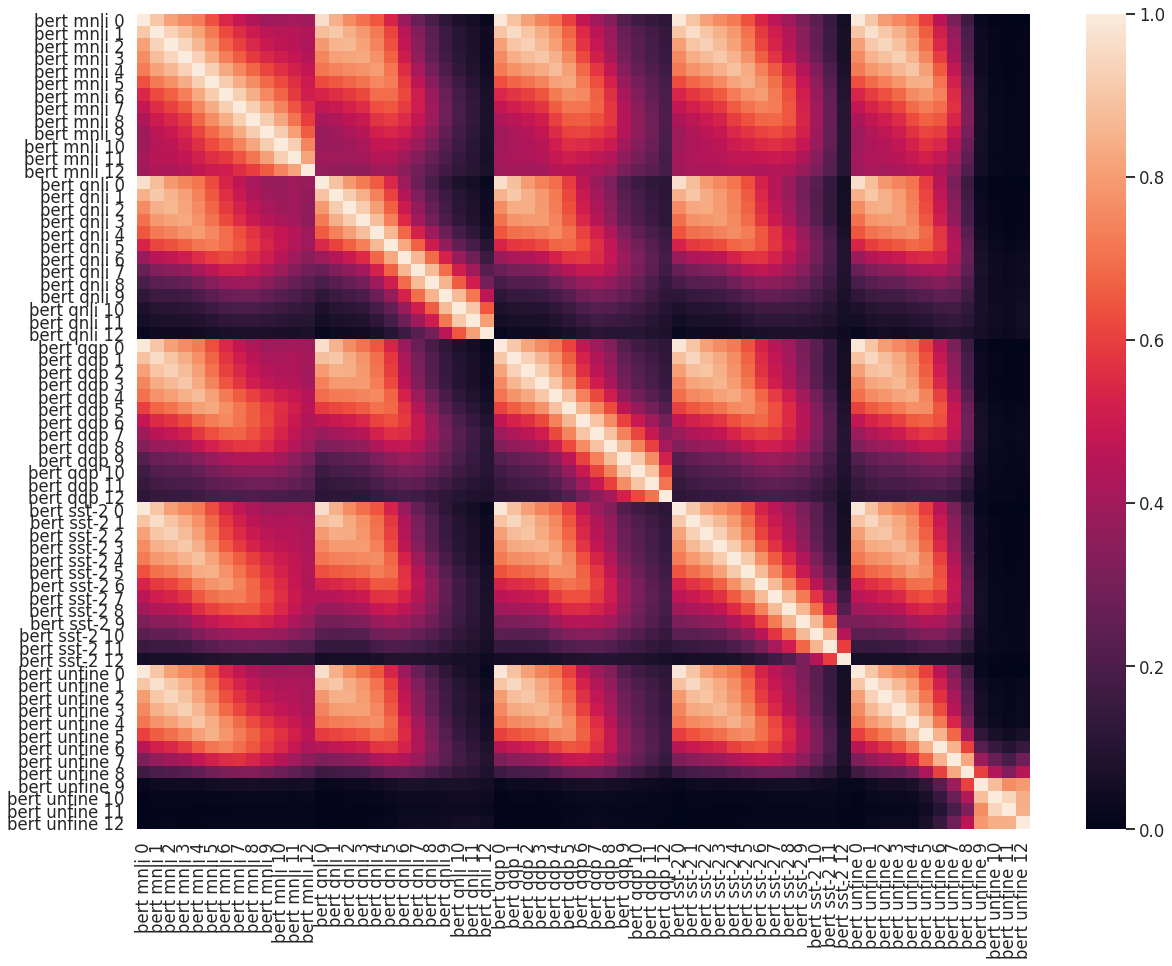

In [22]:
# lincka
g = sns.heatmap(lincka_df.fillna(1), vmin=0, vmax=1, xticklabels=short_labels, yticklabels=short_labels)
g.get_figure().savefig('bert-lincka-heatmap-finetuned.pdf')

In [23]:
def corrs_update(fl, corr_df, fname_prefix, weights_df=None):
    fname = "{0}{1:.2f}.png".format(fname_prefix, fl)
    try:
        im = plt.imread(fname)
        plt.imshow(im)
    except:
        if weights_df is None: # eg. svcca, don't need to do special division
            df = corr_df.applymap(lambda t: float('nan') if type(t) is float else 
                                              t[:int(fl*len(t))].mean())
        else:
            denominator_df = weights_df.applymap(lambda t: float('nan') if type(t) is float else 
                                                             t[:int(fl*len(t))].sum())
            df = corr_df.applymap(lambda t: float('nan') if type(t) is float else
                                            t[:int(fl*len(t))].sum())
            df /= denominator_df
        sns.heatmap(df.fillna(1), vmin=0, vmax=1)
        # sns.heatmap(df.fillna(1), )
        plt.savefig(fname, transparent=True)
        plt.show()

Widget Javascript not detected.  It may not be installed or enabled properly.


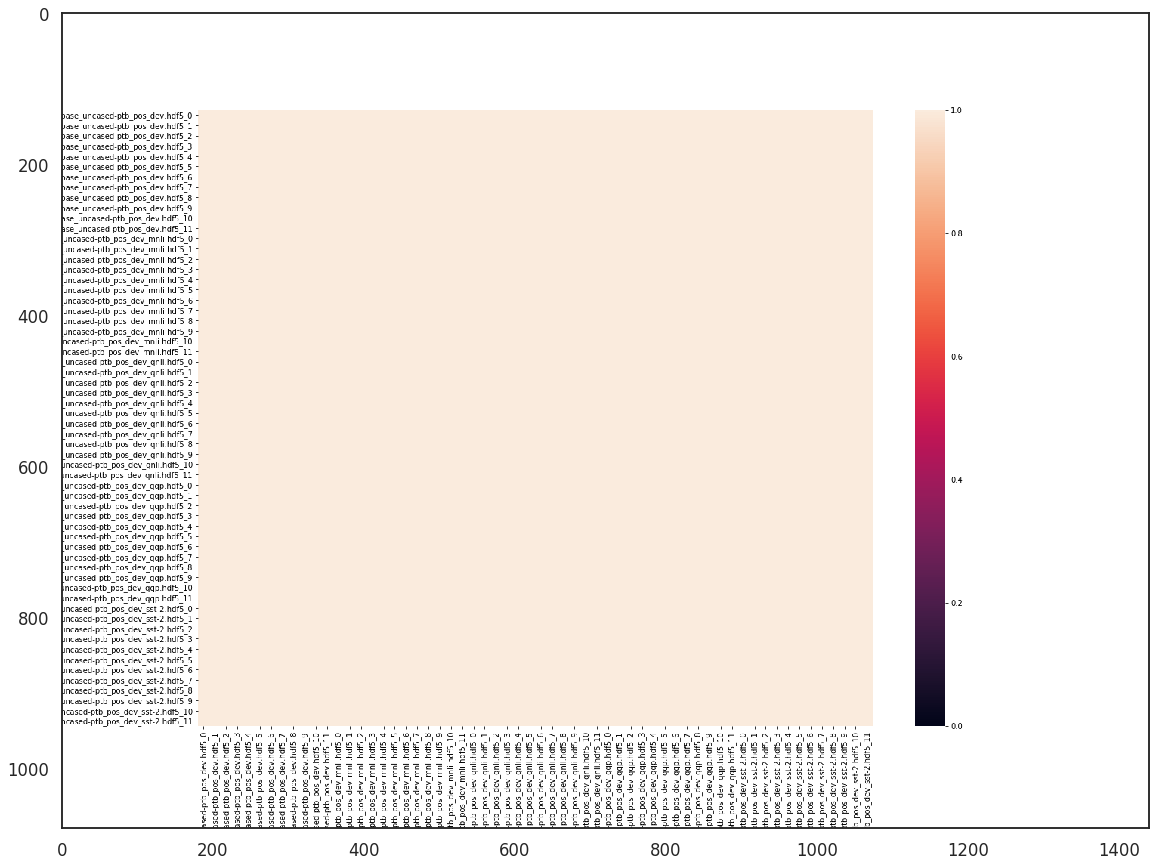

In [24]:
# interactive updates
def pw_update(fl):
    corrs_update(fl, pw_corrs_df, "temp_fine_pw1_", weights_df=pw_alignments_df)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(pw_update, fl=slider)

Widget Javascript not detected.  It may not be installed or enabled properly.


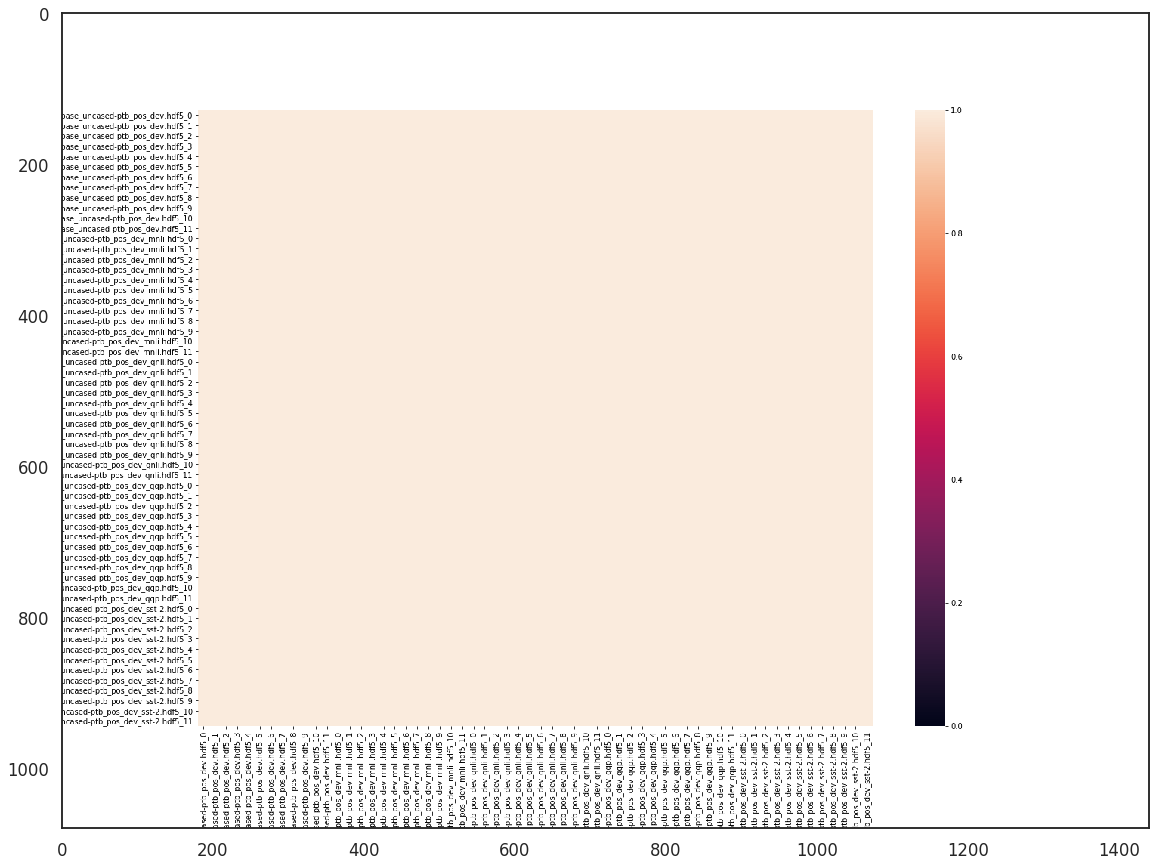

In [25]:
# interactive updates
def sv_update(fl):
    corrs_update(fl, sv_corrs_df, "temp_fine_sv1_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(sv_update, fl=slider)

Widget Javascript not detected.  It may not be installed or enabled properly.


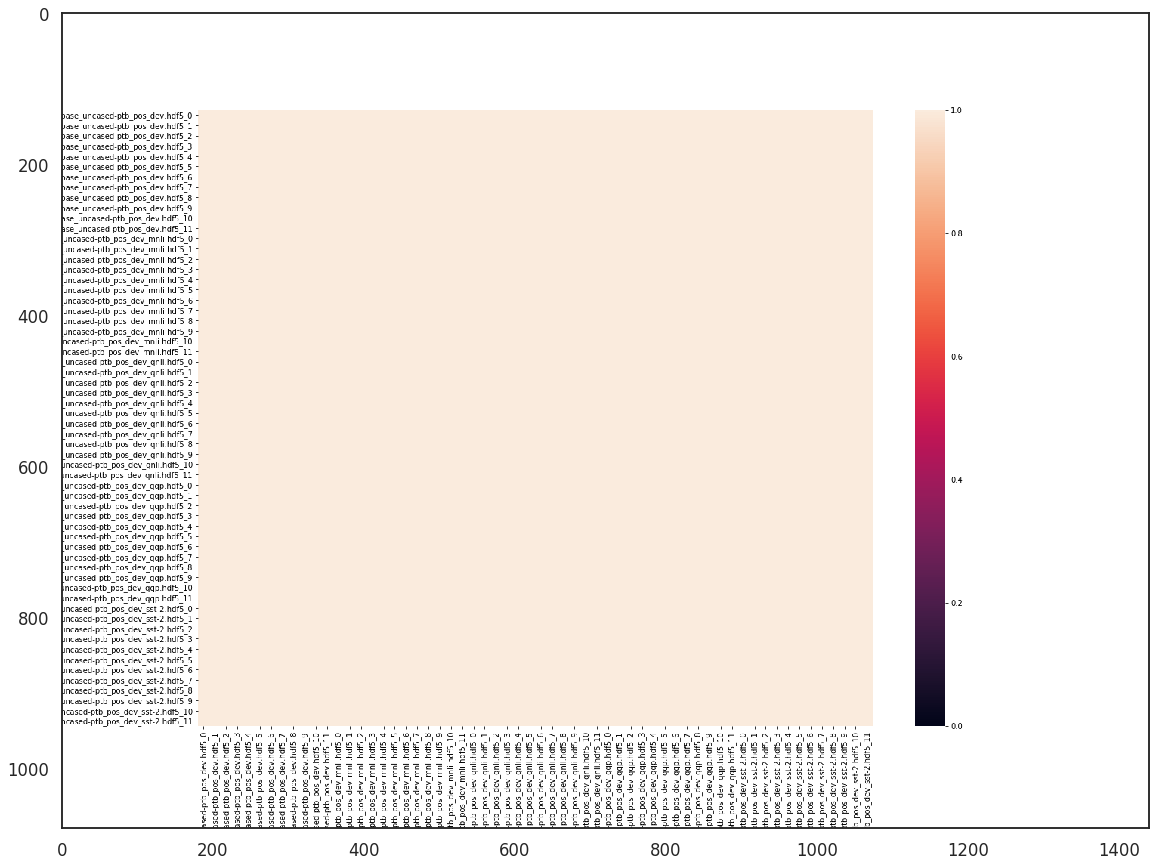

In [26]:
# interactive for maxmincorr
maxmin_corrs = res_d['maxcorr']['corrs']
maxmin_corrs_df = pd.DataFrame(maxmin_corrs).applymap(lambda a: float('nan') if type(a) is float else -np.sort(-a)) # np sort has no reverse keyword
maxmin_corrs_df = maxmin_corrs_df.reindex(maxmin_corrs_df.columns)
def maxmincorr_update(fl):
    corrs_update(fl, maxmin_corrs_df, "temp_fine_maxmincorr1_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(maxmincorr_update, fl=slider)

Widget Javascript not detected.  It may not be installed or enabled properly.


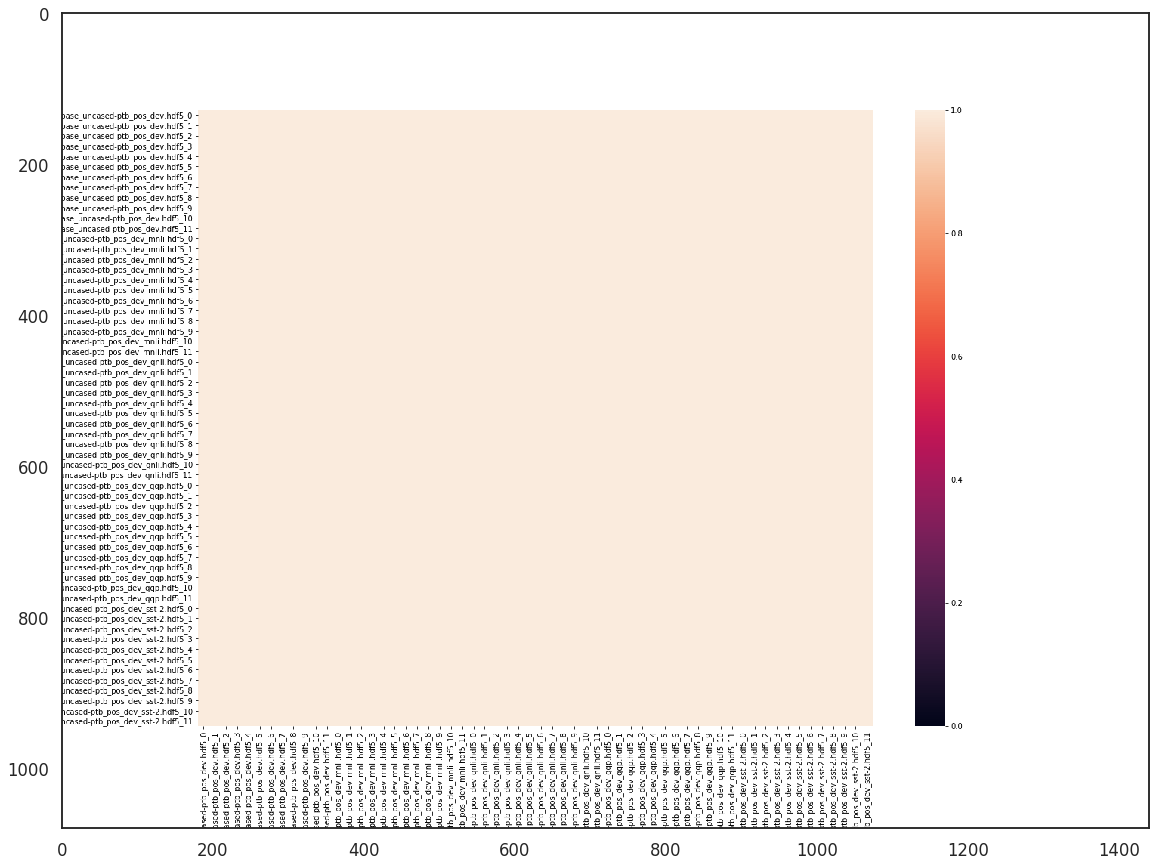

In [27]:
# interactive for linregcorr
linreg_corrs = res_d['maxlinreg']['pred_power']
linreg_corrs_df = pd.DataFrame(linreg_corrs).applymap(lambda a: float('nan') if type(a) is float else -np.sort(-a)) # np sort has no reverse keyword
linreg_corrs_df = linreg_corrs_df.reindex(linreg_corrs_df.columns)
def linregcorr_update(fl):
    corrs_update(fl, linreg_corrs_df, "temp_fine_linregcorr1_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(linregcorr_update, fl=slider)

In [28]:
# rbfcka
# sns.heatmap(rbfcka_df.reindex(rbfcka_df.columns).fillna(1), vmin=0, vmax=1)

In [29]:
# # comparing models
# # use lincka
# model1 = "xlnet"
# model2 = "xlnet"
# cols = [s for s in lincka_df.columns if s.find(model1) >= 0]
# rows = [s for s in lincka_df.columns if s.find(model2) >= 0]

In [30]:
# df = lincka_df.loc[rows, cols]

# sns.heatmap(df, xticklabels=range(len(df.columns)), yticklabels=range(len(df.index)), annot=True)
# plt.xlabel(model1)
# plt.ylabel(model2)
# plt.show()

# Localized vs distributed


In [31]:
locl_meth = "maxcorr"
dist_meth = "cca"

# Localized and distributed dataframes
locl_df = pd.DataFrame(res_d[locl_meth]['similarities'])
locl_df = locl_df.reindex(locl_df.columns)

dist_df = pd.DataFrame(res_d[dist_meth]['sv_similarities'])
dist_df = dist_df.reindex(dist_df.columns)

# Localization and distributivity statistics
locl_ser = locl_df.mean(axis=1)
locl_ser = (locl_ser - locl_ser.mean()) / locl_ser.std()

dist_ser = dist_df.mean(axis=1)
dist_ser = (dist_ser - dist_ser.mean()) / dist_ser.std()

# diff_ser
diff_ser = locl_ser - dist_ser

('bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5', 'bert_base_ca

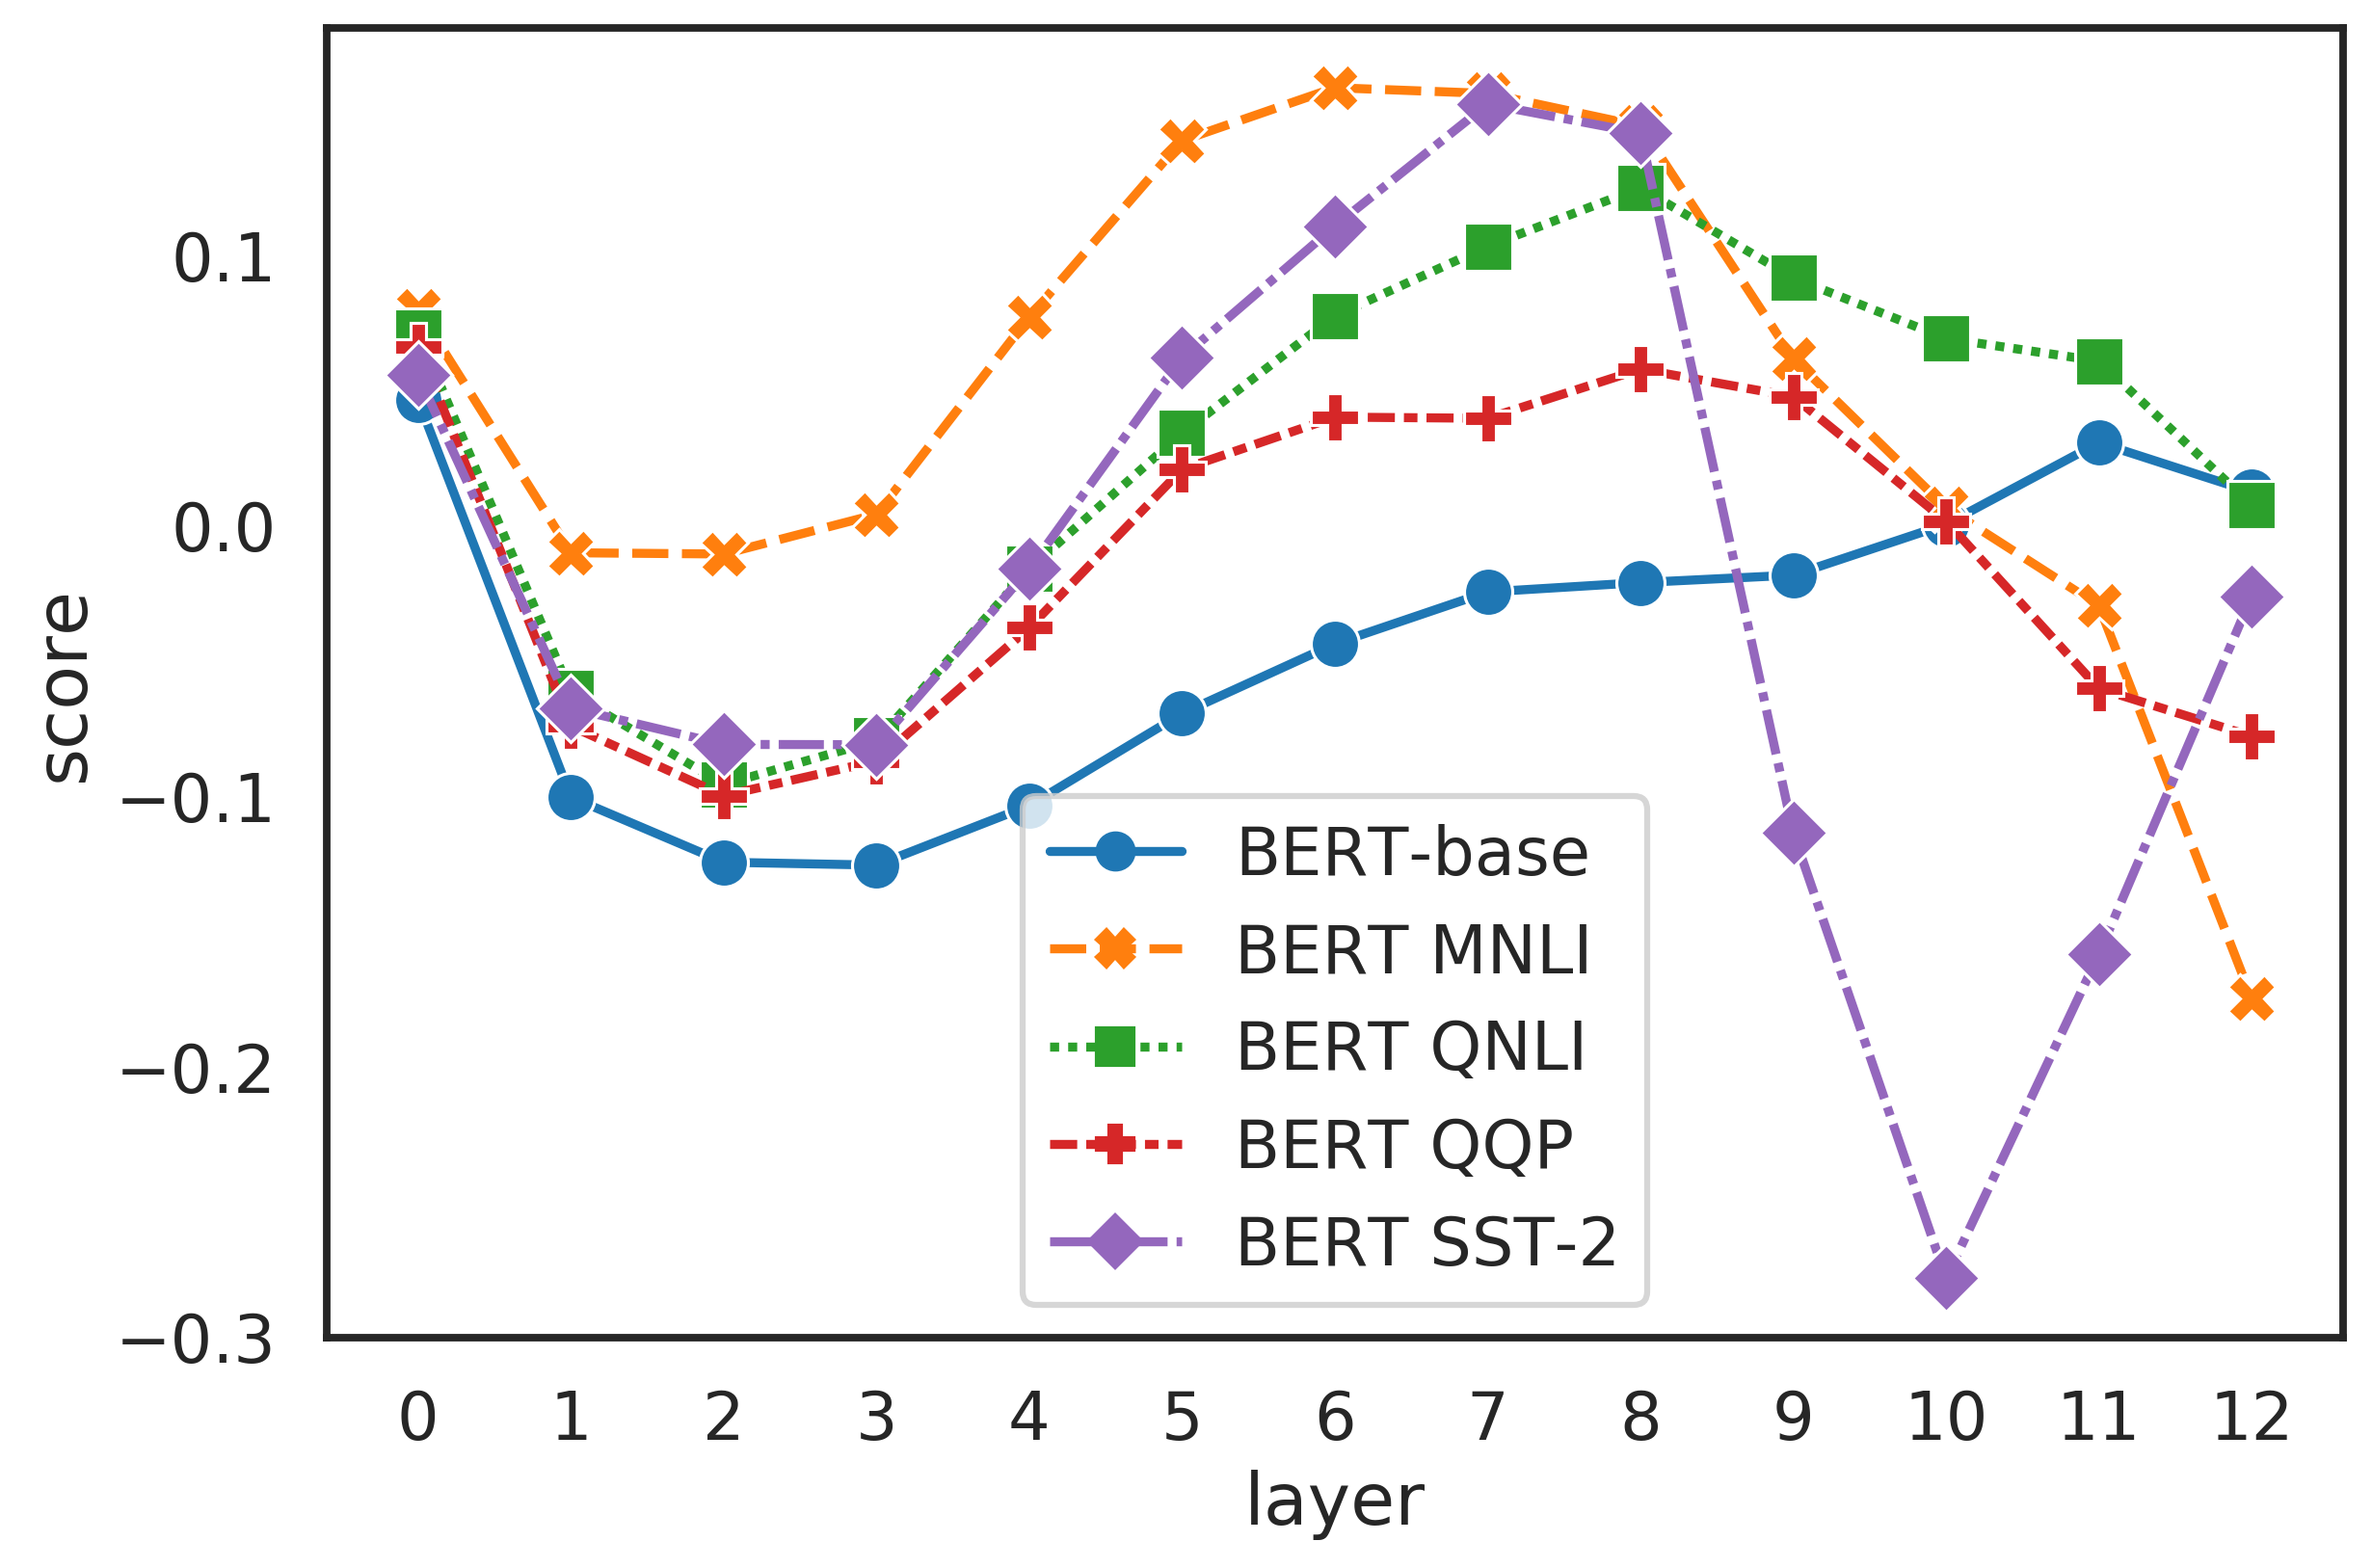

In [32]:
diff_df = pd.DataFrame(diff_ser, columns=['score'])
x = [network_sort_key(layer) for layer in diff_df.index.values]
models, layers = list(zip(*x))
print(models)
models = [model.split('_')[0] + ' ' + model.split('_')[-3] for model in models]
models = ['bert base' if model == 'bert unfine' else model for model in models]
print(models)
print(layers)
diff_df['layer'] = layers
diff_df['model'] = models
diff_df.head()
plt.figure(figsize=(9,6), dpi=300)
g = sns.lineplot(data=diff_df, x='layer', y='score', hue='model', style='model', markers=True, markersize=12)
g.set_xticks(range(13))
handles, labels = g.get_legend_handles_labels()

custom_mapping = {
    "bert mnli": "BERT MNLI",
    "bert qnli": "BERT QNLI",
    "bert qqp": "BERT QQP",
    "bert sst-2": "BERT SST-2",
    "bert base": "BERT-base"
}
labels = [custom_mapping[l] for l in labels[1:]]
g.legend(handles=handles[1:], labels=labels)
# g.set_title('Localization score in layers of BERT models')
g.get_figure().savefig('bert-loc-score.pdf')

In [33]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): # print everything
    print(diff_ser.sort_values())

bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_10    -0.278417
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     -0.174843
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11    -0.158553
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_3    -0.125630
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_2    -0.124555
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_9     -0.113721
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_4    -0.103607
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_1    -0.100530
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_2       -0.099958
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_2      -0.095834
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_3       -0.087127
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_3     -0.081105
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_2     -0.081004
bert_base_cased-ptb_pos_dev_qnli_inclu

In [34]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): # print everything
    print(locl_ser.sort_values())

bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    -2.500381
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11    -2.444012
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_10    -2.042827
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     -1.985062
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12      -1.951866
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11     -1.746926
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_10     -1.504538
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12     -1.388220
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11      -1.379560
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_9     -1.328486
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_9      -1.207550
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_11     -1.100358
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_10      -0.944901
bert_base_cased-ptb_pos_dev_unfine_inc

In [35]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): # print everything
    print(dist_ser.sort_values())

bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    -2.474110
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11    -2.285459
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12      -1.873884
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     -1.810218
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_10    -1.764410
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11     -1.717239
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_10     -1.511041
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12     -1.395680
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11      -1.319244
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_9      -1.269161
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_9     -1.214765
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_11     -1.161090
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_8      -0.955497
bert_base_cased-ptb_pos_dev_qqp_includ